# Zavkhan Meteorological Data Visualization

This notebook creates a meteorological plot for the Zavkhan region, showing snow depth, precipitation, and temperature data with quantile bands for a specific winter year.

## Import Required Libraries

In [1]:
import calendar
from datetime import datetime, timedelta

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib.patches import Rectangle

# Set style
plt.style.use("seaborn-v0_8")
sns.set_palette("husl")

## Utility Functions

In [2]:
# Create a function to map doy_season to actual dates
def doy_season_to_date(doy_season, winter_year):
    """
    Convert day of season to actual date.
    doy_season starts from June 1st (day -213) of the previous year
    and goes to May 31st (day 151) of the winter year.
    """
    # June 1st of the previous year is our reference point (day -213)
    reference_date = datetime(winter_year - 1, 6, 1)

    # Add the days from the reference point
    actual_date = reference_date + timedelta(days=doy_season + 213)

    return actual_date

In [3]:
# Create an enhanced version of dat_sub with time columns
def add_time_columns_to_data(df, winter_year):
    """
    Add comprehensive time columns to a dataframe with doy_season values.
    """
    df_with_time = df.copy()

    # Add the main time column
    df_with_time["time"] = df_with_time["doy_season"].apply(
        lambda x: doy_season_to_date(x, winter_year)
    )

    # Add additional time-related columns
    df_with_time["date"] = df_with_time["time"].dt.date

    # Reorder columns
    time_cols = ["time", "date"]
    other_cols = [col for col in df_with_time.columns if col not in time_cols]
    df_with_time = df_with_time[time_cols + other_cols]
    df_with_time.drop(columns=["time"], inplace=True)

    return df_with_time

## Load and Prepare Data

In [8]:
# Load the data
dat = pd.read_csv("../data/raw/Disaster Resilience/Mongolia/Tabular/zavkhan_data.csv")

# Define parameters
winter_year = 2010

# Define dzud years (severe winter conditions)
dzud_years = pd.DataFrame(
    {
        "year": [1993, 2000, 2001, 2010],
        "rel_sfu": [0.136935694779708, 0.24560724076588, 0.354096907344563, 0.357309474862005],
    }
)

# Define facet labels for variables
facet_labels = {
    "snow_depth": "snow depth",
    "total_precipitation": "precipitation",
    "tx2m": "max. temperature",
}

print(f"Data shape: {dat.shape}")
print(f"Columns: {dat.columns.tolist()}")

Data shape: (54789, 28)
Columns: ['time', 'variable', 'value', 'season', 'season_year', 'season_quarter', 'doy', 'doy_season', 'dzud', 'winter', 'rel_sfu', 'hay', 'rel_hay', 'FD', 'ID', 'CFDN5', 'FTD', 'TXx', 'TXn', 'TNx', 'TNn', 'CWDI', 'CWN', 'CFD', 'meanHS', 'SCD1', 'SCD10', 'SCD21']


## Calculate Month Axis Positions

In [9]:
# Calculate month axis positions (equivalent to R's cumsum and days_in_month)
days_in_months = [calendar.monthrange(2020, i)[1] for i in range(1, 13)]
month_axis = np.cumsum(days_in_months)
month_axis = np.where(month_axis > 151, month_axis - 365, month_axis)
month_axis_lbl = month_axis - days_in_months[-1] / 2  # December days / 2

month_names = list(calendar.month_abbr)[1:]  # Skip empty string at index 0

print(f"Month axis positions: {month_axis}")
print(f"Month axis labels: {month_axis_lbl}")
print(f"Month names: {month_names}")

Month axis positions: [  31   60   91  121 -213 -183 -152 -121  -91  -60  -30    1]
Month axis labels: [  15.5   44.5   75.5  105.5 -228.5 -198.5 -167.5 -136.5 -106.5  -75.5
  -45.5  -14.5]
Month names: ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']


## Process Data - Calculate Quantiles

In [10]:
# Filter out dzud years and calculate quantiles
dat_sub = (
    dat[~dat["season_year"].isin(dzud_years["year"])]
    .groupby(["doy_season", "variable"])["value"]
    .agg(
        [
            ("value_min", lambda x: x.quantile(0.05)),
            ("value_max", lambda x: x.quantile(0.95)),
            ("value_median", lambda x: x.quantile(0.5)),
        ]
    )
    .reset_index()
)

print(f"Processed data shape: {dat_sub.shape}")
print(f"Variables in processed data: {dat_sub['variable'].unique()}")
dat_sub.head()

Processed data shape: (1095, 5)
Variables in processed data: ['snow_depth' 'total_precipitation' 'tx2m']


,doy_season,variable,value_min,value_max,value_median
0,-213,snow_depth,0.000000,0.063446,0.007100
1,-213,total_precipitation,0.005986,3.274992,0.443800
2,-213,tx2m,8.227709,22.924267,16.650927
3,-212,snow_depth,0.000008,0.061338,0.005485
4,-212,total_precipitation,0.002713,4.571661,0.559941


## Create the Meteorological Plot

Plot saved as: zavkhan_meteo-processed-season-2010.png


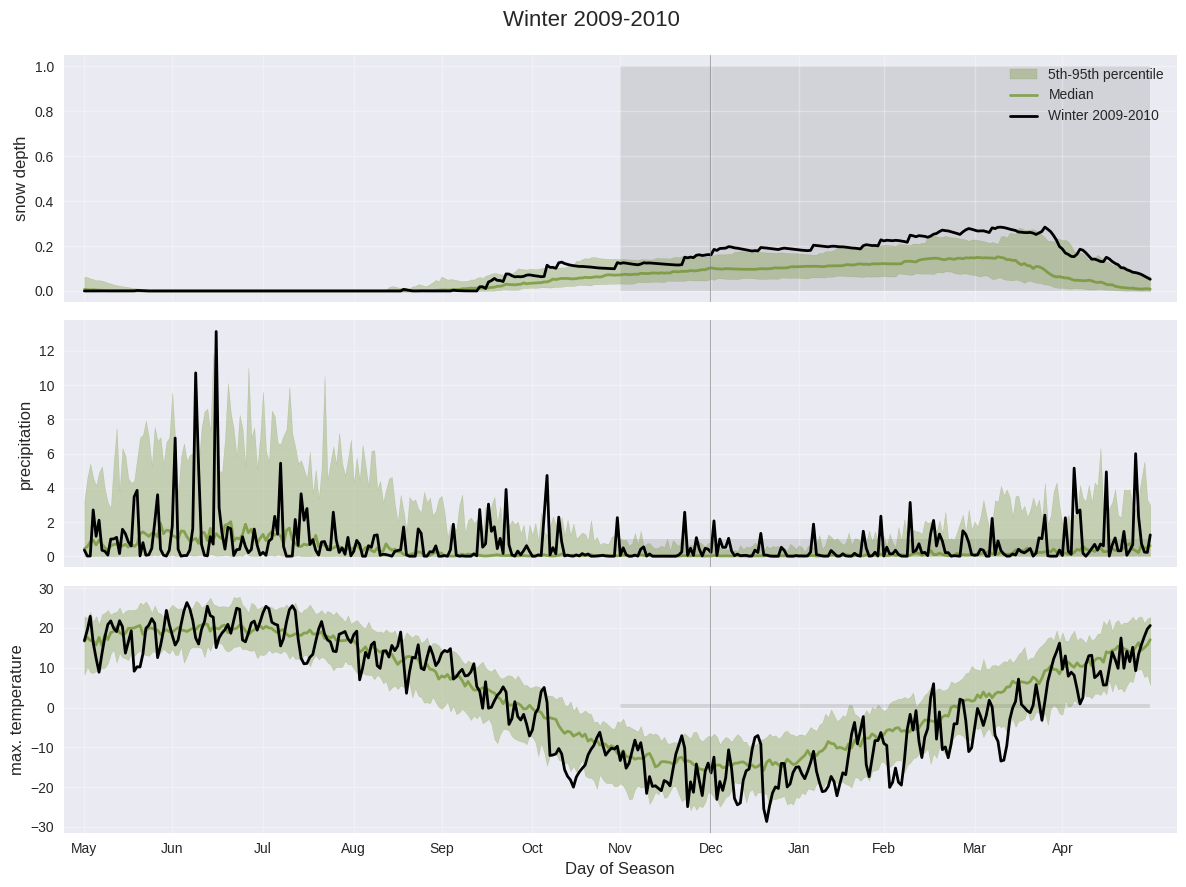

In [11]:
# Get data for the specific winter year
winter_data = dat[dat["season_year"] == winter_year]

# Get unique variables for subplot creation
variables = dat_sub["variable"].unique()
n_vars = len(variables)

# Create the plot
fig, axes = plt.subplots(n_vars, 1, figsize=(12, 9), sharex=True)
if n_vars == 1:
    axes = [axes]

# Color scheme
ribbon_color = "olivedrab"
ribbon_alpha = 0.3
median_color = "olivedrab"
winter_color = "black"

for i, var in enumerate(variables):
    ax = axes[i]

    # Filter data for this variable
    var_data = dat_sub[dat_sub["variable"] == var]
    var_winter = winter_data[winter_data["variable"] == var]

    # Add background rectangle for winter period (-30 to 151 days)
    rect = Rectangle(
        (-30, ax.get_ylim()[0] if ax.get_ylim()[0] != ax.get_ylim()[1] else -1),
        181,
        ax.get_ylim()[1] - ax.get_ylim()[0] if ax.get_ylim()[0] != ax.get_ylim()[1] else 2,
        facecolor="black",
        alpha=0.1,
        zorder=0,
    )
    ax.add_patch(rect)

    # Plot quantile ribbon
    ax.fill_between(
        var_data["doy_season"],
        var_data["value_min"],
        var_data["value_max"],
        color=ribbon_color,
        alpha=ribbon_alpha,
        label="5th-95th percentile",
    )

    # Plot median line
    ax.plot(
        var_data["doy_season"],
        var_data["value_median"],
        color=median_color,
        alpha=0.7,
        linewidth=2,
        label="Median",
    )

    # Plot winter year data
    if not var_winter.empty:
        ax.plot(
            var_winter["doy_season"],
            var_winter["value"],
            color=winter_color,
            linewidth=2,
            label=f"Winter {winter_year-1}-{winter_year}",
        )

    # Add vertical line at day 0.5
    ax.axvline(x=0.5, color="gray", alpha=0.6, linestyle="-", linewidth=0.8)

    # Set y-label with proper variable name
    ylabel = facet_labels.get(var, var)
    ax.set_ylabel(ylabel, fontsize=12)

    # Add grid
    ax.grid(True, alpha=0.3)

    # Only show legend for the first subplot
    if i == 0:
        ax.legend(loc="upper right", fontsize=10)

# Set x-axis for the bottom subplot - NOW SHOWING FULL RANGE
ax = axes[-1]
ax.set_xlim(-220, 160)  # Extended range to show from June (-213) to May (151)
ax.set_xlabel("Day of Season", fontsize=12)

# Set x-axis ticks - SHOWING ALL MONTHS
month_ticks = month_axis  # Use all month positions
month_labels = month_names  # Use all month names
ax.set_xticks(month_ticks)
ax.set_xticklabels(month_labels, fontsize=10)

# Add title
fig.suptitle(f"Winter {winter_year-1}-{winter_year}", fontsize=16, y=0.98)

# Adjust layout
plt.tight_layout()
plt.subplots_adjust(top=0.93)

# Save the plot
filename = f"zavkhan_meteo-processed-season-{winter_year}.png"
plt.savefig(filename, dpi=300, bbox_inches="tight")
print(f"Plot saved as: {filename}")

plt.show()

In [12]:
for i, var in enumerate(variables):
    ax = axes[i]

    # Filter data for this variable
    var_data = dat_sub[dat_sub["variable"] == var]
    var_winter = winter_data[winter_data["variable"] == var]

    var_data["time"] = var_winter["time"].to_list()
    var_data["value"] = var_winter["value"].to_list()

    if i == 0:
        data = var_data.copy()
    else:
        data = pd.concat([data, var_data], ignore_index=True)

data.drop(columns=["doy_season"], inplace=True)
data = data[["variable", "time", "value", "value_median", "value_min", "value_max"]]

data.head()

/tmp/ipykernel_18988/4286780698.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  var_data["time"] = var_winter["time"].to_list()
/tmp/ipykernel_18988/4286780698.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  var_data["value"] = var_winter["value"].to_list()
/tmp/ipykernel_18988/4286780698.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata

,variable,time,value,value_median,value_min,value_max
0,snow_depth,2009-06-01T00:00:00Z,0.0,0.007100,0.000000,0.063446
1,snow_depth,2009-06-02T00:00:00Z,0.0,0.005485,0.000008,0.061338
2,snow_depth,2009-06-03T00:00:00Z,0.0,0.004390,0.000000,0.055922
3,snow_depth,2009-06-04T00:00:00Z,0.0,0.005365,0.000000,0.052495
4,snow_depth,2009-06-05T00:00:00Z,0.0,0.003930,0.000000,0.047473


In [40]:
data.tail()

,variable,time,value,value_median,value_min,value_max
1090,tx2m,2010-05-27T00:00:00Z,13.361156,16.304049,9.562138,22.768694
1091,tx2m,2010-05-28T00:00:00Z,15.841029,14.440398,9.573717,22.824121
1092,tx2m,2010-05-29T00:00:00Z,17.893994,15.061380,7.650735,21.230429
1093,tx2m,2010-05-30T00:00:00Z,19.737155,15.759219,8.133000,22.371565
1094,tx2m,2010-05-31T00:00:00Z,20.608976,17.065102,5.691024,22.695252


In [ ]:
data.to_json(
    "../data/processed/Disaster Resilience/Mongolia/Tabular/"
    "zavkhan_meteo-processed-season-{winter_year}.json",
    orient="records",
    date_format="iso",
)

## Summary Statistics

In [ ]:
# Display some summary information
print("\n=== Analysis Summary ===")
print(f"Winter year analyzed: {winter_year-1}-{winter_year}")
print(f"Dzud years excluded: {dzud_years['year'].tolist()}")
print(f"Variables plotted: {list(facet_labels.values())}")
print("\nData coverage by variable:")
for var in variables:
    var_count = len(dat[dat["variable"] == var])
    winter_count = len(winter_data[winter_data["variable"] == var])
    print(
        f"  {facet_labels.get(var, var)}: {var_count} total points,"
        " {winter_count} winter {winter_year} points"
    )


=== Analysis Summary ===
Winter year analyzed: 2009-2010
Dzud years excluded: [1993, 2000, 2001, 2010]
Variables plotted: ['snow depth', 'precipitation', 'max. temperature']

Data coverage by variable:
  snow depth: 18263 total points, 365 winter 2010 points
  precipitation: 18263 total points, 365 winter 2010 points
  max. temperature: 18263 total points, 365 winter 2010 points
